## Классификация вероятности срыва по каждому отчёту

In [1]:
# Other tools
import pickle
import random
import torch # (нужен для проверки использования GPU)
import glob
import os

from typing_extensions import Literal, Any, Callable, List
from collections import Counter
from tqdm import tqdm
from copy import deepcopy

# Train
import sklearn

from sklearn.model_selection import KFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Oversampling
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

# Model
import catboost
import optuna

def gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

/Users/bondarchukgleb/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Session settings
pd.set_option('display.max_rows', 15)

plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'

# make results reproducable
def set_seed(seed=42):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(SEED)

SEED = 1
set_seed(SEED)

"""
1 - Добавление кастомных фичей
2 - Овер-сэмплинг с помощью SMOTE
"""
PIPELINE = 2

In [3]:
import pandas as pd

In [4]:
X_train = pd.read_csv("data_final/train_X.csv")
y_train = pd.read_csv("data_final/train_y.csv")

train = X_train.merge(y_train, on=["contract_id", "report_date"], how="left")
test = pd.read_csv("data_final/test2_X.csv")

In [4]:
# adding contractor new graph features
graph_cols = []
graph_features = pd.read_csv("generated_features/contractor_graph_features_v2.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")
graph_cols.extend(graph_features.columns)

# adding contractor new graph features
graph_features = pd.read_csv("generated_features/contractor_graph_features_v3.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")
graph_cols.extend(graph_features.columns)

In [124]:
features = pd.read_csv("utils/features_named.csv", index_col=0)
rename_dict = {x[0]: x[1] for x in features[["колонка", "описание"]].values}


In [125]:
train = train[list(rename_dict.keys()) + ["contract_id", "default6"]]
test = test[list(rename_dict.keys()) + ["contract_id"]]

In [126]:
all_data = pd.concat([train, test], axis=0)

- *Дропаем колонки, где нанов больше чем 3/5 длины датасета*
- *Иначе заполняем медианой*

In [127]:
isna_stat = train.isna().sum()[train.isna().sum() > 0]
features2drop = [col for col in isna_stat.index if isna_stat[col] > (train.shape[0] * (3/5))]
train.drop(columns=features2drop, inplace=True)
test.drop(columns=features2drop, inplace=True)

imputers = {}
for col in isna_stat.index:
  if col not in features2drop:
    imp = SimpleImputer(strategy="median").fit(train[col].values.reshape(-1, 1))
    train[col] = imp.transform(train[col].values.reshape(-1, 1))
    test[col] = imp.transform(test[col].values.reshape(-1, 1))
    imputers[col] = imp
    
# убеждаемся, что нанов нет
assert len(train.isna().sum()[train.isna().sum() > 0]) == 0

Добавим к каждому отчёту длину контракта и текущий номер отчёта в контракте.

In [128]:
train["contract_length"] = 0
train["sample_num"] = 0

for i in tqdm(train["contract_id"].unique()):
    train.loc[train["contract_id"] == i, "contract_length"] = (train["contract_id"] == i).sum()
    train.loc[train["contract_id"] == i, "sample_num"] = np.arange((train["contract_id"] == i).sum())
    
    
test["contract_length"] = 0
test["sample_num"] = 0

for i in tqdm(test["contract_id"].unique()):
    test.loc[test["contract_id"] == i, "contract_length"] = (test["contract_id"] == i).sum()
    test.loc[test["contract_id"] == i, "sample_num"] = np.arange((test["contract_id"] == i).sum())

100%|█████████████████████████████████████| 2281/2281 [00:00<00:00, 2978.95it/s]


In [129]:
#translate to timestamp
dates_columns = train.select_dtypes('object').columns

for date_col in dates_columns:
  train[date_col] = train[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())
  test[date_col] = test[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())

In [130]:
unique_ids_features = ["contract_id", "contractor_id", "project_id", "specialization_id"]

contract_id_col = "contract_id"
unique_ids_cols = [col for col in unique_ids_features if col != contract_id_col]
target_column = "default6"

In [131]:
ts_features = pickle.load(open("generated_features/time_series_features.pickle", "rb"))
always_const_f = pickle.load(open("generated_features/constant_features_list.pickle", "rb"))

*Маппим значения id-шнкиов, так чтобы они были от 0 до n, где n - кол-во уникальных значений*

In [132]:
cat_feature_mappers = {}

In [133]:
for cat_feat in unique_ids_cols:

  print(len(set(test[cat_feat].unique()) & set(train[cat_feat].unique())))
  print(f"uniuqe values in {cat_feat}:", len(set(test[cat_feat].unique()) | set(train[cat_feat].unique())))


  cat_mapper = {item : i for i, item in enumerate
      (
        list(
          set(list(train[cat_feat].unique())) | set(list(test[cat_feat].unique()))
        )
      )
  }
  cat_feature_mappers[cat_feat] = cat_mapper

  train[cat_feat] = train[cat_feat].map(cat_mapper)
  train[cat_feat] = train[cat_feat].astype(np.int16)

  test[cat_feat] = test[cat_feat].map(cat_mapper)
  test[cat_feat] = test[cat_feat].astype(np.int16)

394
uniuqe values in contractor_id: 847
48
uniuqe values in project_id: 55
29
uniuqe values in specialization_id: 32


Переведём в отдельный класс категориальные признаки, которые не пересекаются в трейне и тесте.

In [134]:
cat_features = features[features["тип признака"] == "categorical"]["колонка"].tolist()
replaced_features = {}

for f in cat_features:
    for_replace = (set(train[f]) | set(test[f])) - (set(train[f]) & set(test[f]))
    replaced_features[f] = for_replace
    train.loc[train[f].isin(for_replace), f] = -1
    test.loc[test[f].isin(for_replace), f] = -1

In [135]:
features = pd.read_csv("utils/features_named.csv", index_col=0)
rename_dict = {x[0]: x[1] for x in features[["колонка", "описание"]].values}

test.rename(rename_dict, axis=1, inplace=True)
train.rename(rename_dict, axis=1, inplace=True)

## **CatBoost c Stratified Group KFold (если без оверсэмплинга, иначе просто Group)**

*Кастомный класс для работы с CatBoost*

In [136]:
class CatBoostWorker:
  def __init__(
      self,
      task: Literal['reg', 'class'] = "reg",
      seed: int = 1,
      device: Literal['CPU', 'GPU'] ="CPU"
  ) -> None:
      pass

      """
        Column name:  | Default value:      | Column description:
                      |                     |
        task          | default: 'reg'      | whether this catboost will solve regression('reg') on classification('class') task
        seed          | default: 1          | random state to make result reproducable
        device        | default: 'CPU'      | device to compute ('CPU'/'GPU')

      """

      # Init-params
      self.seed = seed
      self.device = device
      self.task = task


      # Default splits data
      self.train_data = None
      self.val_data = None
      self.test_data = None


      # CV setting
      self.num_folds = None
      self.folds = None
      self.cross_val_test_pool = None
      self.cross_val_score = None

      # Models settings
      self.default_model_params = {
          "iterations" : 100,
          "border_count" : 254
      }
      self.default_train_params = {}


      # Models

      self.model = None
      self.folds_models = None


  def split_data(
      self,
      data: Any = None,
      target_column: str = "target" ,
      fold: bool = False,
      splits: dict = {"train" : 1.0, "val" : None, "test" : None},
      extra_features_columns: dict  = {},
      verbose: bool = True
  ) -> None:

    """

      Column name:           | Default value:                                        | Column description:
                             |                                                       |
      data                   | default: None                                         | dataframe
      target_column          | default: 'target'                                     | name of target column
      splits                 | default: {"train" : 1.0, "val" : None, "test" : None} | train/val/test splits sizes
      extra_features_columns | default: {}                                           | columns with specifical data for catboost like cat_features, embedding_features, text_features
      verbose                | default: True                                         | whether show progress of data initalizing or not

    """

    self.extra_features_columns = extra_features_columns

    # getting train/val/test actual sizes
    train_size = int(len(data) * splits["train"])

    val_size = 0.0
    test_size = 0.0
    if splits["val"] != None:
      val_size = int(len(data) * splits["val"])

    if splits["test"] != None:
      test_size = int(len(data) * splits["test"])

    if verbose:

      print(f"train size: {train_size}, val size: {val_size}, test_size: {test_size}")

    # shake data
    np.random.seed(self.seed)
    data = data.sample(frac=1).reset_index(drop=True)

    # saving train/val/test splits to catboost Pools
    X = data.drop(columns=[target_column])
    Y = data[target_column]

    X_train_split = X.iloc[:train_size, :]
    Y_train_split = Y.iloc[:train_size]
    self.train_data = (X_train_split, Y_train_split)

    if val_size != 0.0:

      X_val_split = X.iloc[train_size:train_size + val_size, :].reset_index(drop=True)
      Y_val_split = Y.iloc[train_size:train_size + val_size].reset_index(drop=True)
      self.val_data = (X_val_split, Y_val_split)

    if test_size != 0.0:

      X_test_split = X.iloc[train_size + val_size:, :].reset_index(drop=True)
      Y_test_split = Y.iloc[train_size + val_size:].reset_index(drop=True)
      self.test_data = (X_test_split, Y_test_split)

    if verbose:

      print("all pools have been succesfully saved :)")


  def split_folds(
      self,
      data: Any = None,
      target_column: str = "target" ,
      cv_type: Literal['Classic', 'Stratified'] = "Classic",
      num_folds: int = 5,
      test_size: int = 0.1,
      extra_features_columns: dict  = {},
      verbose: bool = True,
      groups : List = []
  ) -> None:

    """

      Column name:           | Default value:                                        | Column description:
                             |                                                       |
      data                   | default: None                                         | dataframe
      target_column          | default: 'target'                                     | name of target column
      num_folds              | default: 5                                            | number of folds for create
      cv_type                | default: 'Classic'                                    | type of cross-validation
      test_size              | default: 0.1                                          | test-size
      verbose                | default: True                                         | whether show progress of data initalizing or not
      groups                 | default: []                                           | Groups for StratifiedGroupKFold
    """

    self.extra_features_columns = extra_features_columns

    self.num_folds = num_folds

    # test split
    if test_size != 0.0:

      cv_size = int(len(data) * (1 - test_size))

      #shake data
      np.random.seed(self.seed)
      data = data.sample(frac=1).reset_index(drop=True)

      # saving train/val/test splits to catboost Pools
      X = data.drop(columns=[target_column])
      Y = data[target_column]

      X_cv_data = X.iloc[:cv_size, :]
      Y_cv_data = Y.iloc[:cv_size]

      X_test_data = X.iloc[cv_size:, :]
      Y_test_data = Y.iloc[cv_size:]
      self.cross_val_test_data = (X_test_data, Y_test_data)

      if verbose:

        print(f"cv_size: {cv_size}, test_size: {len(data) - cv_size}")

    else:

      X_cv_data = data.drop(columns=[target_column])
      Y_cv_data = data[target_column]

    # getting folds
    if cv_type == "Classic":

      kf = sklearn.model_selection.KFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed)

    if cv_type == "Stratified":

      kf = sklearn.model_selection.StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed)

    if cv_type == "StratifiedGroup":

      kf = sklearn.model_selection.StratifiedGroupKFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed)

    if cv_type == "Group":

      kf = sklearn.model_selection.GroupKFold(n_splits=self.num_folds)

    if self.task == "reg":

      Y_to_split_on = pd.qcut(Y_cv_data, self.num_folds, labels = np.arange(self.num_folds))

    folds_data = {}

    split_args = dict(
        X=X_cv_data,
        y=(Y_to_split_on if (self.task == "reg" and cv_type == "Stratified") else Y_cv_data)
    )

    if cv_type in ["Group", "StratifiedGroup"]:
      split_args["groups"] = groups

    for fold, (train_idxs, val_idxs) in enumerate(kf.split(
        **split_args
    )):

      X_train_fold, y_train_fold = X_cv_data.iloc[train_idxs, :], Y_cv_data.iloc[train_idxs]
      X_val_fold, y_val_fold = X_cv_data.iloc[val_idxs, ], Y_cv_data.iloc[val_idxs]
        
      over_sampler = SMOTENC(categorical_features=cat_features, k_neighbors=10)
      X_train_resampled, y_train_resampled = over_sampler.fit_resample(
          X_train_fold,
          y_train_fold
      )


      folds_data[f"fold_{fold}"] = ((X_train_resampled, y_train_resampled), (X_val_fold, y_val_fold))

      if verbose:

        print(f"fold {fold} saved")

    self.folds = folds_data

  def init_model_params(
      self,
      model_params: dict = {"iterations" : 100},
      train_params: dict = {}
  ) -> None:

      """
        Column name:           | Default value:                                        | Column description:
                               |                                                       |
        model_params           | default: {"iterations" : 100}                         | dict with catboost model initialization params
        train_params           | default: {}                                           | dict with catboost model .fit params

      """

      self.default_model_params = model_params
      self.default_train_params = train_params


  def train_model(self) -> None:

    if self.task == "reg":

      self.model = catboost.CatBoostRegressor(
          **self.default_model_params,
          random_state=self.seed,
          task_type=self.device
      )

    if self.task == "class":

      self.model = catboost.CatBoostClassifier(
          **self.default_model_params,
          random_state=self.seed,
          task_type=self.device
      )

    train_pool = catboost.Pool(data=self.train_data[0], label=self.train_data[1], **self.extra_features_columns)

    eval_sets = [train_pool] + ([] if self.val_data == None else [catboost.Pool(data=self.val_data[0], label=self.val_data[1], **self.extra_features_columns)])

    self.model.fit(X=train_pool, eval_set=eval_sets, **self.default_train_params)

  def train_kfold(
      self,
      eval_metric: Callable = None,
      verbose: bool = True,
  ) -> None:

    """
        Column name:           | Default value:                       | Column description:

        eval_metric            | default: None                        | metric to evaluate cross-valadation on
        verbose                | default: True                        | whether to verbose evaluation process or no
    """

    folds_scores = []
    folds_models = []

    for fold in range(self.num_folds):
      train_fold_data, val_fold_data = self.folds[f"fold_{fold}"]

      train_fold_pool = catboost.Pool(data=train_fold_data[0], label=train_fold_data[1], **self.extra_features_columns)
      val_fold_pool = catboost.Pool(data=val_fold_data[0], label=val_fold_data[1], **self.extra_features_columns)

      if self.task == "reg":

        fold_model = catboost.CatBoostRegressor(
            **self.default_model_params,
            random_state=self.seed,
            task_type=self.device
        )

      if self.task == "class":

        fold_model = catboost.CatBoostClassifier(
            **self.default_model_params,
            random_state=self.seed,
            task_type=self.device,
        )

      eval_sets = [train_fold_pool, val_fold_pool]

      fold_model.fit(X=train_fold_pool, eval_set=eval_sets, **self.default_train_params)

      fold_val_preds = fold_model.predict_proba(val_fold_pool)[:, 1]
      fold_val_score = eval_metric(val_fold_pool.get_label(), fold_val_preds)

      folds_scores.append(fold_val_score)
      folds_models.append(fold_model)

      if verbose:
        print(f"FOLD {fold}, VAL SCORE: {fold_val_score}")

    if verbose:
      print()
      print(f"mean val score per folds {np.mean(folds_scores)}")
      print(f"mean val score per folds with regularization {np.mean(folds_scores) - np.std(folds_scores)}")

    self.cross_val_score = np.mean(folds_scores)
    self.folds_models = folds_models
    self.folds_scores = folds_scores


  def inference_model(
    self,
    return_probs: bool = False,
    target_threshold: float = 0.5,
    use_kfold_models: bool = False,
    test_pool = None,
  ):

    """
        Column name:           | Default value:                       | Column description:

        return_probs           | default: False                       | whether to return probes or preds
        target_threshold       | default: 0.5                         | threshold to make preds from probes
        use_kfold_models       | default: False                       | use or not KFold models to eval on test_set
        test_pool              | default: None                        | custom test_set to evaluate on
    """

    data_to_inference = None

    if test_pool is not None:
      data_to_inference = test_pool
    elif use_kfold_models:
      data_to_inference = catboost.Pool(data=self.cross_val_test_pool[0], label=self.cross_val_test_pool[1], **self.extra_features_columns)
    else:
      data_to_inference = catboost.Pool(data=self.test_data[0], label=self.test_data[1], **self.extra_features_columns)

    if data_to_inference is None:
      raise Exception("no data to inference")


    if use_kfold_models:

      all_models_preds = []
      for model in self.folds_models:

        model_preds = model.predict_proba(data_to_inference)[:, 1]
        all_models_preds.append(model_preds)

      if return_probs:
        return all_models_preds
      else:

        probes = np.stack(all_models_preds).mean(axis=0)
        final_preds = (probes > target_threshold).astype(int)
        return final_preds

    else:

      probes = self.model.predict_proba(data_to_inference)

      if return_probs:

        return probes

      else:

        return (probes[:, 1] > target_threshold).astype(int)

### **Запускаем обучение**

**Схема работы с классом:**
1. Инициализируем класс
2. Настраиваем разбивку на фолды
3. Выбираем параметры модели
4. Запускаем обучение

In [137]:
worker = CatBoostWorker(
    task='class',
    seed=1,
    device='CPU'
)

In [138]:
cat_features = [rename_dict[x] for x in cat_features]

In [139]:
cat_features

['идентификатор подрядчика',
 'идентификатор объекта',
 'идентификатор специализации',
 'идентификатор проекта']

In [140]:
train

,Начальная сумма контракта,Текущая сумма контракта за {n} недел{m},Общее количество контрактов,Количество заявок на сдачу работ за {n} недел{m},Общее количество заявок на сдачу работ,Общее количество заявок на сдачу работ контрагента,Общая сумма принятых заявок на сдачу работ за {n} недел{m},Общая сумма принятых заявок на сдачу работ,Общая сумма принятых заявок на сдачу работ контрагента,Среднее время между заявками за {n} месяц{m},...,Степень схожести с другими подрядчиками метрика 87,Степень схожести с другими подрядчиками метрика 88,идентификатор подрядчика,идентификатор объекта,идентификатор специализации,идентификатор проекта,contract_id,default6,contract_length,sample_num
0,1.115267,0.793952,-0.539030,-0.255766,0.145409,-0.165919,-0.168947,1.078326,0.224666,-1.461131,...,0.000009,0.010634,411,701,18,41,5433,0,15,0
1,1.608002,2.681675,0.743673,0.808046,0.487614,-0.165919,-0.168947,1.530308,0.224666,-1.461142,...,0.000009,0.010634,411,268,18,29,6875,0,1,0
2,-0.360764,-0.416432,-0.539030,-0.255766,-0.333678,-0.165919,-0.168947,-0.352688,0.224666,0.684412,...,0.000009,0.010634,411,268,18,29,1476,0,7,0
3,-0.089303,-0.193827,-0.539030,-0.255766,-0.025694,1.807540,-0.168947,0.232536,3.543837,-1.461092,...,0.000004,0.009577,457,697,12,41,4469,0,17,0
4,-0.515778,0.133446,0.743673,-0.255766,-0.162576,1.807540,-0.168947,0.710726,3.543837,0.684412,...,0.000004,0.009577,457,224,12,47,1330,0,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,-0.484227,-0.504509,0.743673,-0.255766,-0.333678,-0.277288,-0.168947,-0.352688,-0.387349,0.684412,...,0.000007,0.010725,645,915,21,16,5078,0,15,14
28827,-0.500003,-0.524174,0.743673,-0.255766,-0.333678,-0.277288,-0.168947,-0.352688,-0.387349,0.684412,...,0.000007,0.010725,645,915,21,16,3854,0,15,14
28828,-0.481102,-0.515112,-0.539030,-0.255766,-0.333678,-0.277288,-0.168947,-0.352688,-0.387349,0.684412,...,0.000007,0.010725,645,298,21,48,5351,0,1,0
28829,-0.468450,-0.504737,-0.539030,-0.255766,-0.333678,-0.277288,-0.168947,-0.352688,-0.387349,0.684412,...,0.000007,0.010725,645,915,21,43,57,0,19,18


In [141]:
groups_dict = {k : i for i, k in enumerate(train["contract_id"].unique())}

worker.split_folds(
    data=train.drop(columns=[contract_id_col]),
    target_column="default6",
    cv_type=("Group" if PIPELINE == 2 else "StratifiedGroup"),
    num_folds=5,
    test_size=0.0,
    verbose=True,
    groups=train["contract_id"].apply(lambda x: groups_dict[x]).tolist()
)

fold 0 saved
fold 1 saved
fold 2 saved
fold 3 saved
fold 4 saved


Подберём гипперпараметры с помощью optuna

In [142]:
# установим подобранные оптюной гиппераметры

model_params = dict(
    iterations=1000,
    max_depth=8,
    border_count=254,
    eval_metric="AUC",
    early_stopping_rounds=50,
    use_best_model=True,
    auto_class_weights="Balanced",
    boosting_type="Ordered",
    # learning_rate=0.01,
    verbose=25,
    colsample_bylevel=0.098,
    subsample=0.9,
    l2_leaf_reg=14,
    min_data_in_leaf=300,
    # max_bin=200,
    random_strength=1,
)

worker.init_model_params(
    model_params=model_params,
)

In [143]:
def normalized_gini(label, preds):
  auc = sklearn.metrics.roc_auc_score(label, preds)
  return 2 * auc - 1

worker.train_kfold(
    #можно использовать как gini, так и просто roc_auc

    # eval_metric="normalized_gini",
    eval_metric=sklearn.metrics.roc_auc_score
)

0:	test: 0.7621353	test1: 0.6184826	best: 0.6184826 (0)	total: 29.1ms	remaining: 29.1s
25:	test: 0.9284508	test1: 0.7008533	best: 0.7081451 (21)	total: 606ms	remaining: 22.7s
50:	test: 0.9613291	test1: 0.7262670	best: 0.7266061 (49)	total: 1.22s	remaining: 22.7s
75:	test: 0.9772124	test1: 0.7317733	best: 0.7322948 (74)	total: 1.8s	remaining: 21.9s
100:	test: 0.9841496	test1: 0.7324983	best: 0.7352335 (96)	total: 2.36s	remaining: 21s
125:	test: 0.9876192	test1: 0.7351051	best: 0.7357211 (117)	total: 2.92s	remaining: 20.2s
150:	test: 0.9902984	test1: 0.7372004	best: 0.7382684 (140)	total: 3.48s	remaining: 19.6s
175:	test: 0.9922659	test1: 0.7411973	best: 0.7413379 (174)	total: 4.04s	remaining: 18.9s
200:	test: 0.9937709	test1: 0.7436945	best: 0.7439278 (199)	total: 4.61s	remaining: 18.3s
225:	test: 0.9950248	test1: 0.7463644	best: 0.7463644 (225)	total: 5.18s	remaining: 17.7s
250:	test: 0.9959131	test1: 0.7435748	best: 0.7464772 (226)	total: 5.74s	remaining: 17.1s
275:	test: 0.9965990	te

In [145]:
pickle.dump([inference_worker.folds_models, inference_worker.folds_scores],
            open("models/single_sample_clf.pickle", "wb"))

In [146]:
# сохраняем модели

chkp_path = "cat_chkps_1"
if not os.path.exists(chkp_path):
  os.mkdir(chkp_path)

for fold, model in enumerate(worker.folds_models):
  model.save_model(f"{chkp_path}/cat_with_features_{fold}.cbm")

## **Делаем submission**

In [147]:
inference_worker = CatBoostWorker(
    task='class',
    seed=1,
    device='CPU'
)

PATH_TO_CHECKPOINTS = "cat_chkps_1"

loaded_models = []
for model_path in sorted(glob.glob(f"{PATH_TO_CHECKPOINTS}/*")):
  print(model_path)
  model = catboost.CatBoostClassifier()
  model.load_model(model_path)
  loaded_models.append(model)

inference_worker.folds_models = loaded_models
inference_worker.folds_scores = worker.folds_scores
# подставить веса

cat_chkps_1/cat_with_features_0.cbm
cat_chkps_1/cat_with_features_1.cbm
cat_chkps_1/cat_with_features_2.cbm
cat_chkps_1/cat_with_features_3.cbm
cat_chkps_1/cat_with_features_4.cbm


*Получаем предсказания на каждом фолде и затем усредняем их с весами*

In [148]:
test_pool = catboost.Pool(data=test.drop(columns=contract_id_col))

probs = inference_worker.inference_model(
    return_probs=True,
    use_kfold_models=True,
    test_pool=test_pool
)

w = inference_worker.folds_scores
# w = [0, 0, 1, 0, 0]
probs = (np.stack(probs) * np.array(w).reshape(-1, 1)).sum(axis=0) / np.sum(w)

In [ ]:
P

*Смотрим на распределения вероятностей*

*Сохраняем результат*

In [33]:
sub = pd.read_csv("data_partfinal/test2_X.csv")

In [34]:
sub["score"] = probs

In [35]:
sub = sub[["contract_id", "report_date", "score"]]

In [36]:
# сохраняем результат
sub_name = "sub_baseline"
sub.to_csv(f"{sub_name}.csv", index=False)

In [37]:
(sub["score"] > 0.5).sum() / len(sub)

0.08837772397094432

<Axes: xlabel='score', ylabel='Count'>

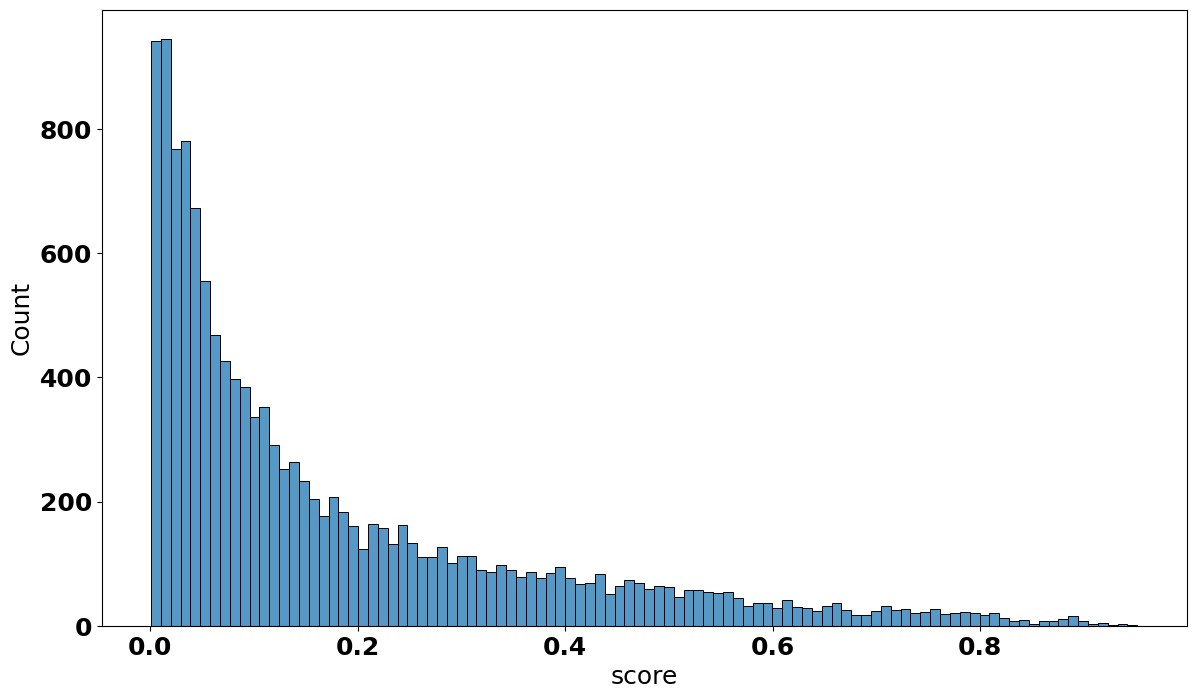

In [38]:
sns.histplot(sub["score"], bins=100)

In [ ]:
for i in sub["contract_id"].unique():
    sub.loc[sub["contract_id"] == i, "score"] = sub[sub["contract_id"] == i]["score"].mean()

In [77]:
sub.to_csv(f"sub_with_oversampling.csv", index=False)